In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-28 21:14:41.549164


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 32
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-0.7299)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-9.4924)
penalty_target_min tensor(-6.1619) penalty_target_max tensor(25.1555)
train_loss:  -5.0555214637756345
valid_loss:  -4.199367366993427
h_min_tilde -6.1618633 ell_tilde -4.884290644419193 kappa_tilde 0.0008847227428769057
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -2.836566122937202
valid_loss:  -1.7634852746009824
weight_alpha 1.0 h_min_tilde -6.1618633 ell_tilde -2.621949953269958 kappa_tilde 0.0005315005065846587


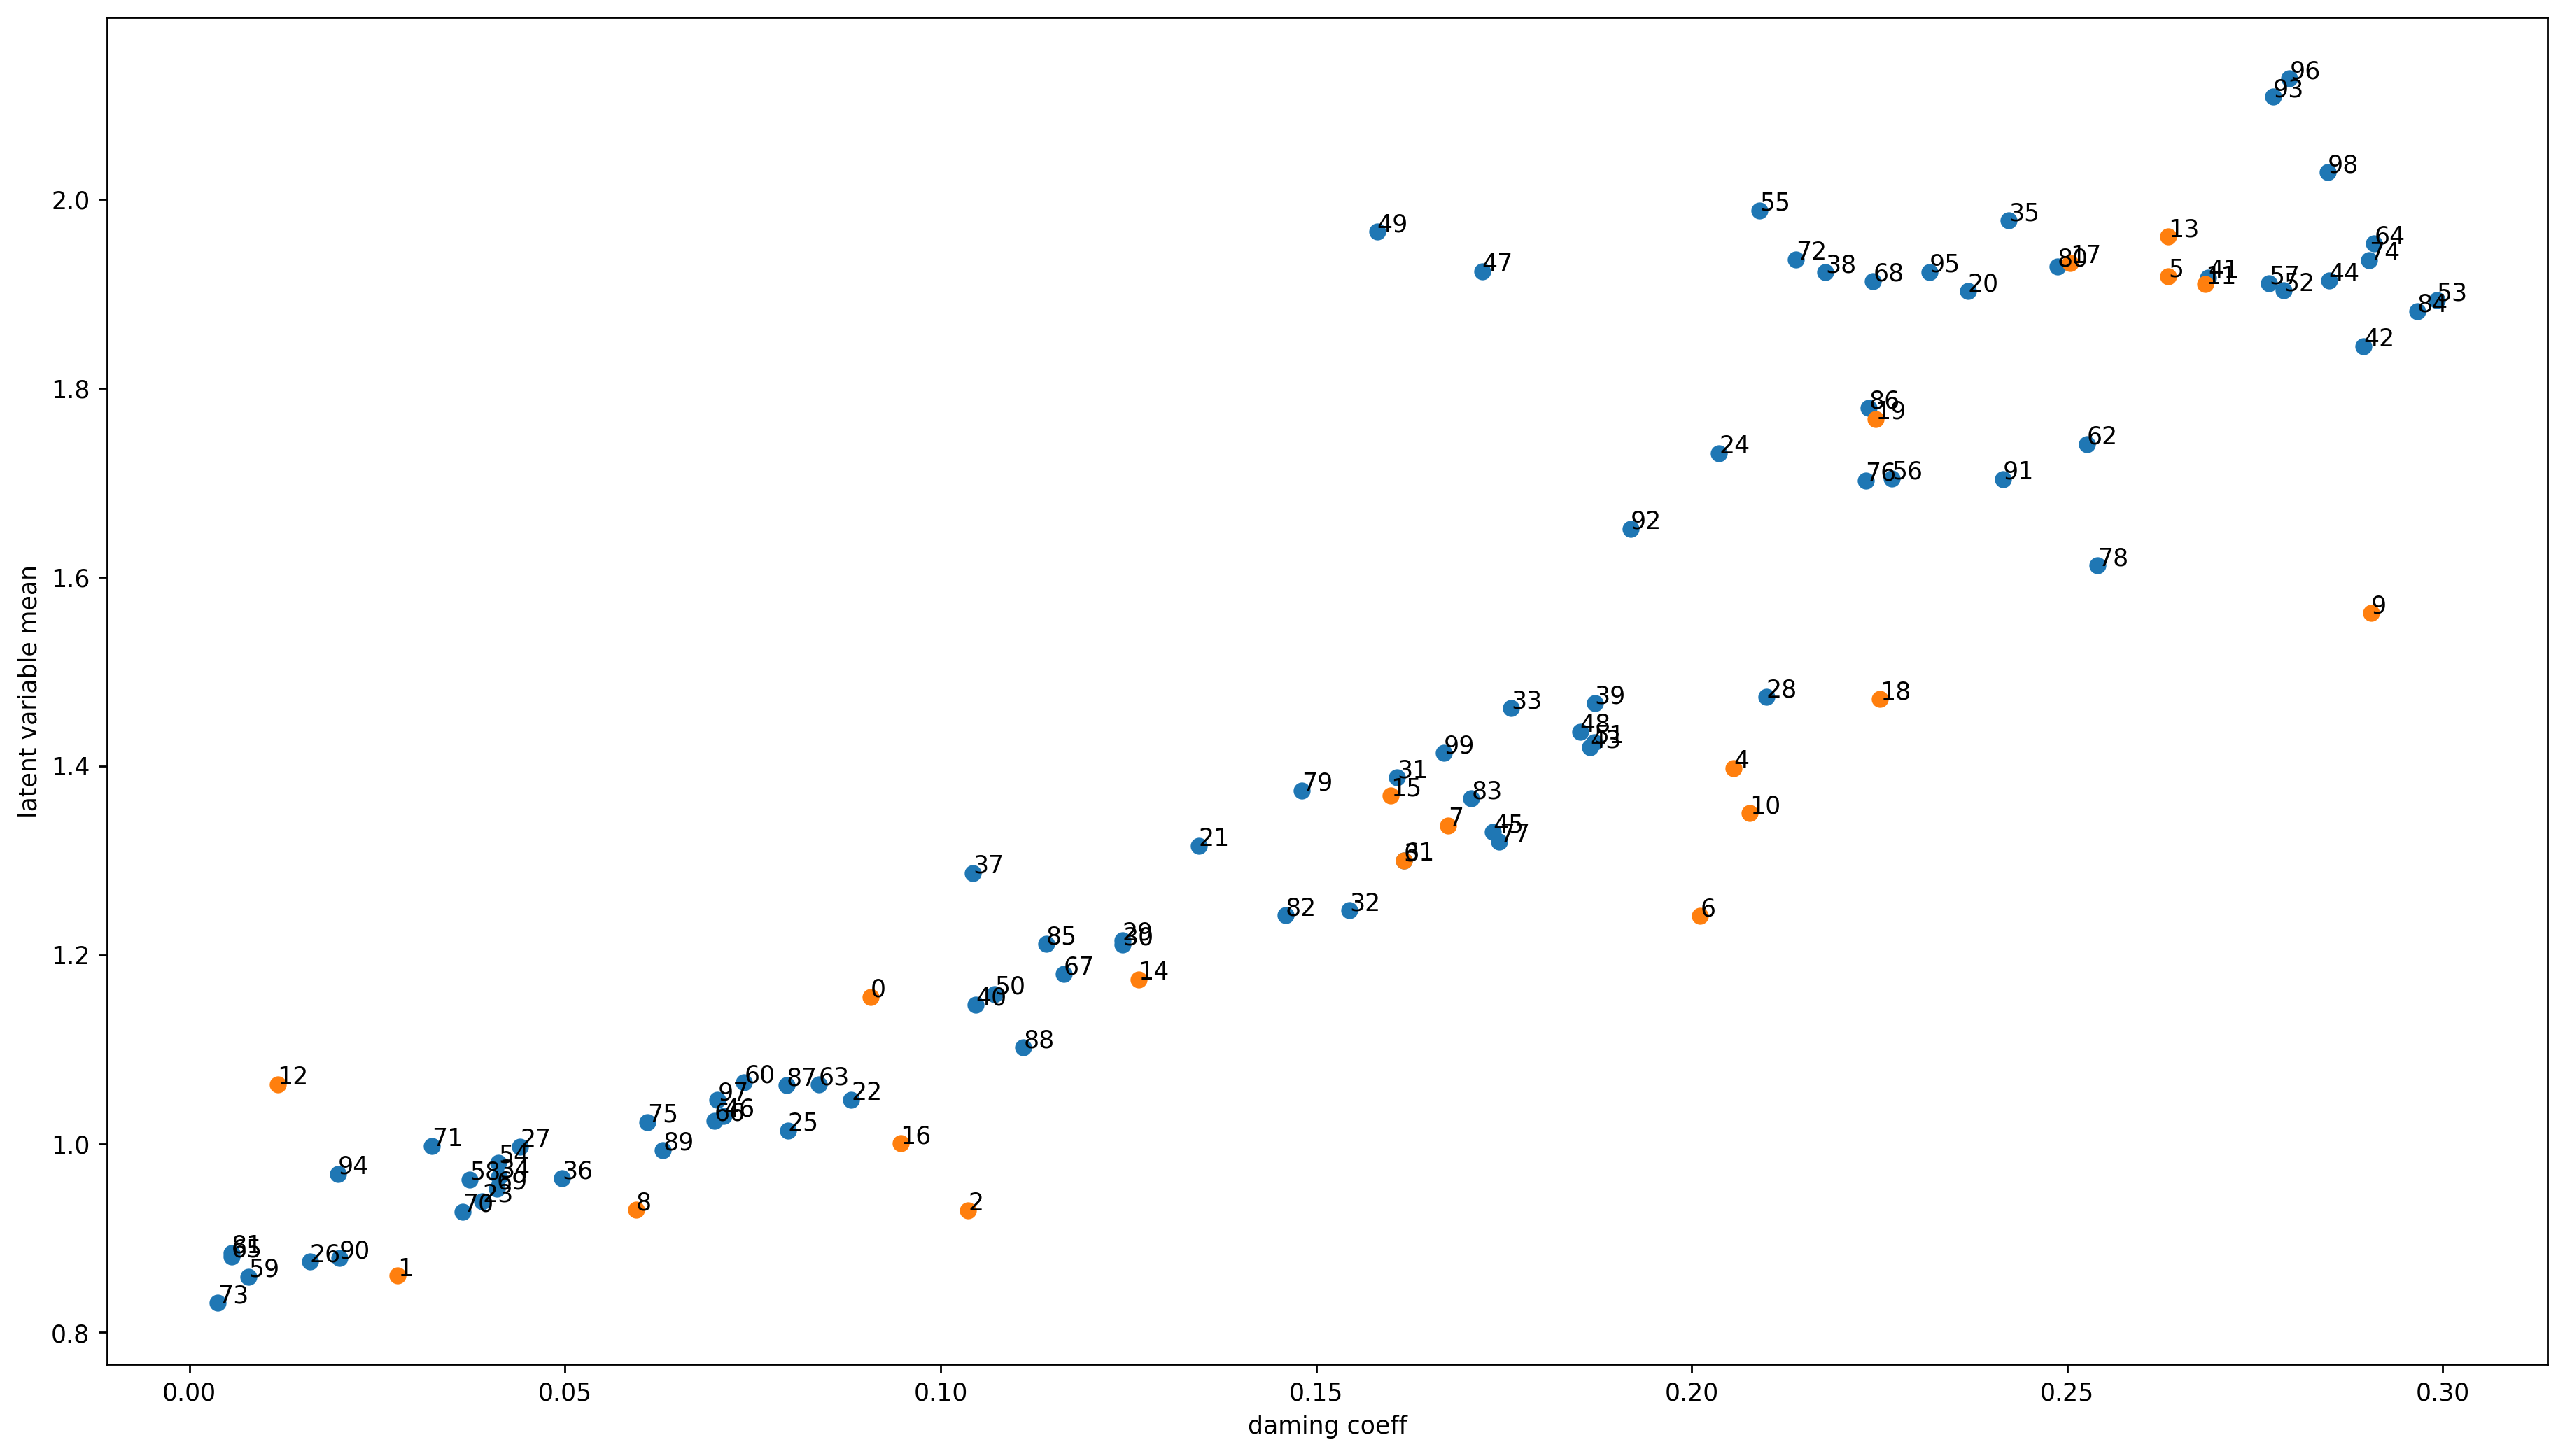

[0.09069977 0.02770158 0.10366822 0.16164502 0.20556585 0.26343523
 0.20114025 0.16760695 0.05943045 0.29047847]
[0.20769678 0.268382   0.01171643 0.26344275 0.12633229 0.15994959
 0.09465469 0.2503877  0.22504329 0.2244497 ]
[0.2367838  0.13436806 0.08808424 0.03900857 0.20365066 0.079664
 0.01600876 0.04401857 0.20992751 0.1242168 ]
[0.12425378 0.16076892 0.15446673 0.17596651 0.04124241 0.24221739
 0.04960626 0.10432976 0.2177994  0.18710166]
[0.1046695  0.26876587 0.28945201 0.18650872 0.28484678 0.17351688
 0.07110809 0.17210385 0.18514347 0.15811743]
[0.10718093 0.18700803 0.27883117 0.29919686 0.04114072 0.20904545
 0.22663892 0.27690736 0.03728129 0.0078633 ]
[0.07386332 0.16164932 0.25260927 0.0837551  0.29087872 0.00559419
 0.06989228 0.11635819 0.22413649 0.04093657]
[0.03640304 0.03224824 0.21389669 0.00376679 0.2901829  0.06098797
 0.22314776 0.17440768 0.25404864 0.14813091]
[0.24869427 0.00557286 0.14590353 0.17065543 0.29658485 0.11404235
 0.22360033 0.07947587 0.111025

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 6.796448707580566

 2 6.320937395095825

 3 6.34637188911438

 4 6.508831977844238

 5 6.553322792053223

 6 3.448213577270508

 7 3.635829448699951

 8 3.062863826751709

 9 3.135284900665283

 10 3.1583335399627686

 11 3.225245714187622

 12 3.12866473197937

 13 3.2039482593536377

 14 3.103073835372925

 15 3.098289966583252

 16 3.0595569610595703

 17 3.0933520793914795

 18 3.24178409576416

 19 3.2581140995025635

 20 3.243333339691162

 21 3.2456741333007812

 22 3.174321174621582

 23 3.254519462585449

 24 3.2183098793029785

 25 3.2699382305145264

 26 3.2836015224456787

 27 3.177579402923584

 28 3.323482036590576

 29 3.2915093898773193

 30 3.1944427490234375

 31 3.353313446044922

 32 3.200599193572998

 33 3.346440076828003

 34 3.3417625427246094

 35 3.2690393924713135

 36 3.28718638420105

 37 3.3278369903564453

 38 3.3740291595458984

 39 3.276627779006958

 40 3.4335379600524902

 41 3.5151240825653076

 42 3.604550838470459

 43 3.613854169845581

 44 3.

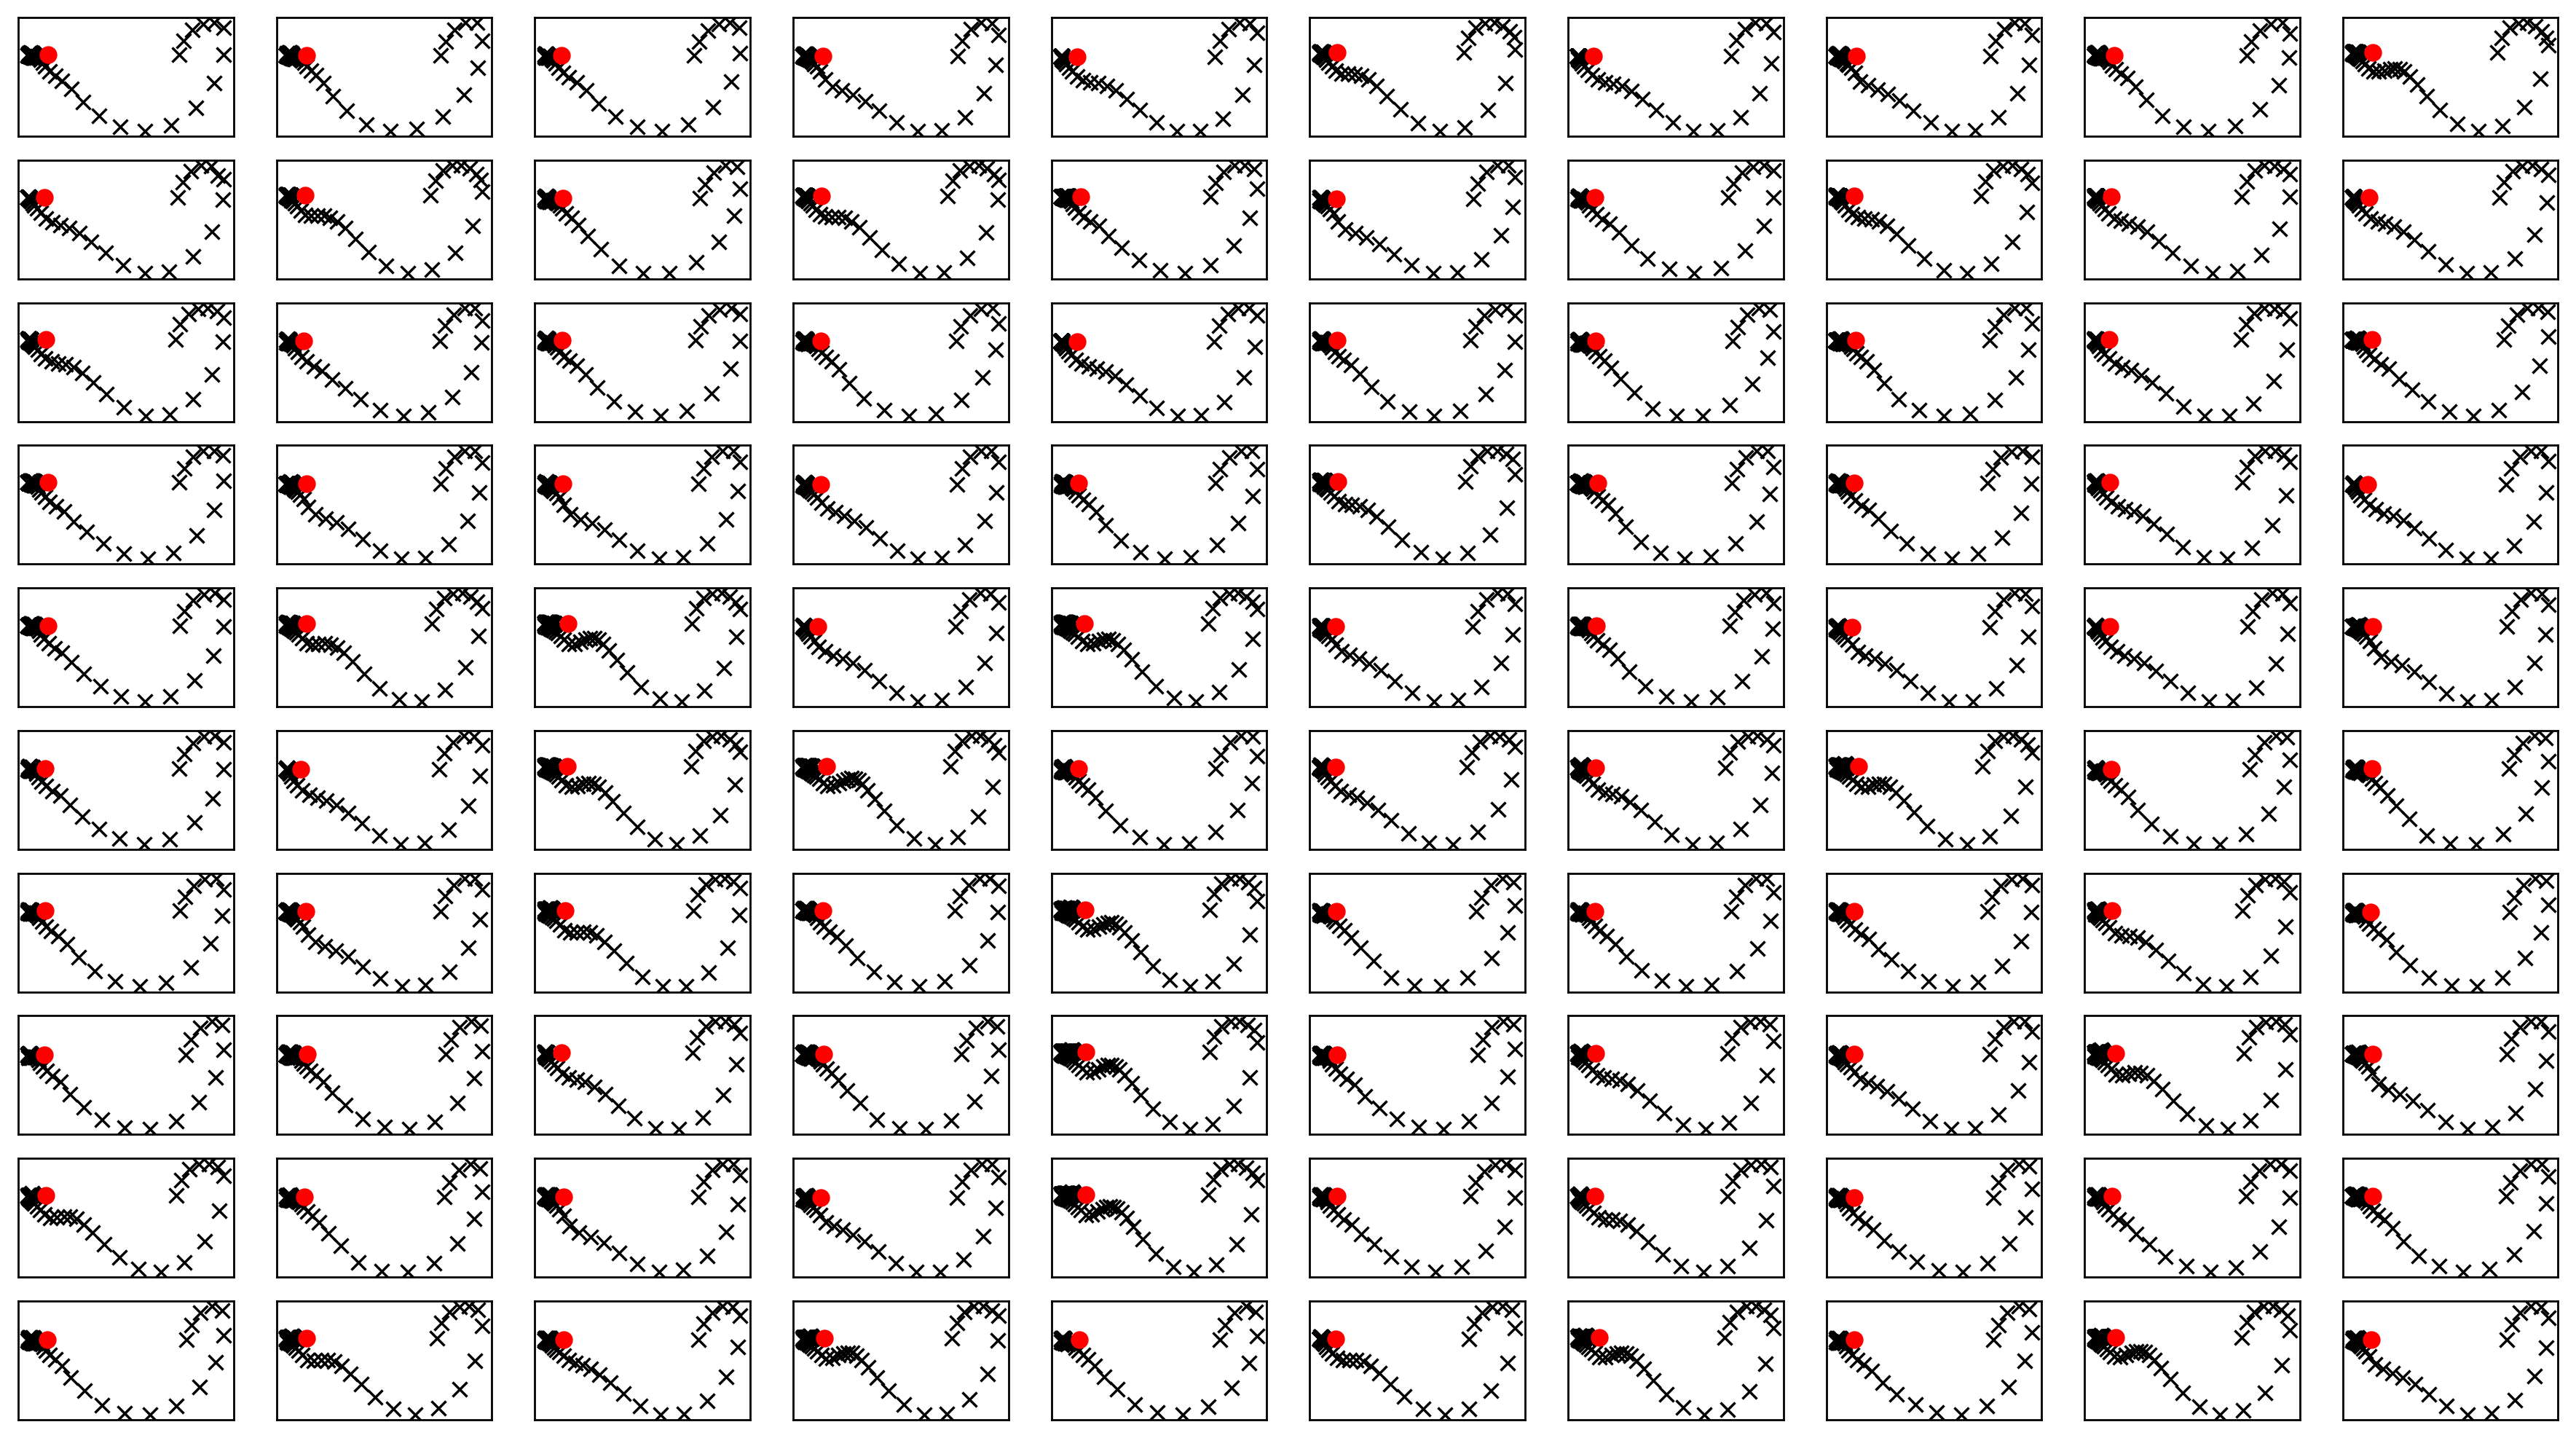

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.6742565631866455

 2 3.8326611518859863

 3 3.7541325092315674

 4 3.6077969074249268

 5 3.7585370540618896

 6 3.8007657527923584

 7 3.630373239517212

 8 3.6386358737945557

 9 3.7577064037323

 10 3.6468241214752197

 11 3.698204517364502

 12 3.6941888332366943

 13 3.769061326980591

 14 3.755690097808838

 15 3.77346134185791

 16 3.845784902572632

 17 3.731917381286621

 18 3.723459243774414

 19 3.7185781002044678

 20 3.777811288833618

 21 3.783860206604004

 22 3.78678297996521

 23 3.8989651203155518

 24 3.793752431869507

 25 3.883833885192871

 26 3.810537099838257

 27 3.7782466411590576

 28 3.839175224304199

 29 3.751771926879883

 30 3.7789225578308105

 31 3.777249336242676

 32 3.723304033279419

 33 3.852010726928711

 34 3.848906993865967

 35 3.749868631362915

 36 3.820406913757324

 37 3.813584566116333

 38 3.7762598991394043

 39 3.6159567832946777

 40 3.8022634983062744

 41 3.8167288303375244

 42 3.7330822944641113

 43

In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())